In [10]:
import math
from math import e
import numpy as np
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt

In [2]:
# Convert a continuous rate to annual rate

def continuous_to_annual(r: float):
    continuoustoannual = e**(r) - 1
    return round(continuoustoannual, 8)

continuous_to_annual(0.05)

0.0512711

In [17]:
# Convert an annual rate to a continuous rate

def annual_to_continuous(i: float):
    annualtocontinuous = np.log(1 + i)
    return round(annualtocontinuous, 8)

annual_to_continuous(0.05)

0.04879016

In [3]:
# Convert an annual rate to a mthly compounded rate

def annual_to_mthly(i: float, m: int):
    annualtomthly = m * ((1 + i)**(1 / m) - 1)
    return round(annualtomthly, 8)

annual_to_mthly(0.05, 6)


0.04898908

In [4]:
# Convert a mthly compounded rate to annual

def mthly_to_annual(i: float, m: int):
    mthlytoannual = (1 + (i / m))**(m) - 1
    return round(mthlytoannual, 8)

mthly_to_annual(0.05, 4)

0.05094534

In [11]:
# Converts discount factor (zero coupon bond) to continuous rate

def zcb_to_continuous(z: float, t: float):
    zcbtocontinuous = -1 * (np.log(z) / t)
    return round (zcbtocontinuous, 8)

zcb_to_continuous(0.85, 3)

0.05417298

In [5]:
# Converts continuous rate to discount factor (zero coupon bond)

def continuous_to_zcb(r: float, t: float):
    continuoustozcb = e**(-1 * r * t)
    return round(continuoustozcb, 8)

continuous_to_zcb(0.05, 3)

0.86070798

2. Bootstrap function

In [23]:
def bootstrap(par_yields: np.ndarray, tenors: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    if len(par_yields) != len(tenors):
        raise ValueError("Mismatch between the number of par yields and tenors.")

    if not np.all(np.diff(tenors) > 0):
        raise ValueError("Tenors are provided that are not strictly monotonic increasing.")
    

    par_yield_t = np.array([3, 4, 5, 6])
    par_yield_r = par_yield_t / (100 * 2)
    C = np.array(list(par_yield_r) * len(par_yield_r)).reshape(len(par_yield_r),len(par_yield_r)).T

    C_2 = C * np.tri(len(par_yield_r), len(par_yield_r))
    C_3 = C_2 + np.identity(4)

    discount_factors = solve_triangular(C_3, np.ones((len(par_yield_r))), lower=True)
    print(discount_factors)
    # Calculate the tenor fractions at half-year intervals
    half_year_intervals = np.arange(0.5, tenors[-1] + 0.5, 0.5)
    print(half_year_intervals)
    return discount_factors, half_year_intervals



[[1.015 0.    0.    0.   ]
 [0.02  1.02  0.    0.   ]
 [0.025 0.025 1.025 0.   ]
 [0.03  0.03  0.03  1.03 ]]
[0.98522167 0.96107408 0.92813913 0.88715238]
[0.5 1.  1.5 2. ]


(array([0.98522167, 0.96107408, 0.92813913, 0.88715238]),
 array([0.5, 1. , 1.5, 2. ]))

3. Zero bond / discount factor function

In [36]:

def zcb(t: float, curve: 'tuple[np.ndarray, np.ndarray]') -> float:
    tenors, rates = curve
    
    
    if t in tenors:
        return 1 / (1 + rates[np.where(tenors == t)][0] / 100)
    
    
    lower_tenor = max(tenors[tenors < t])
    upper_tenor = min(tenors[tenors > t])
    
   
    lower_rate = rates[tenors == lower_tenor][0] / 100
    upper_rate = rates[tenors == upper_tenor][0] / 100
    
    discount_factor = 1 / (1 + np.interp(t, [lower_tenor, upper_tenor], [lower_rate, upper_rate]))
    
    return discount_factor



4. Annuity function

In [3]:

def annuity(n: int, i: float):
    if i==0:
        return n
    else:
        annuityfunction = (1 - (1 + i) ** -n) / i
        return annuityfunction

5. Bond mechanics

In [ ]:
par_rate = {0.5:3.5,
            1:4.2,
            2:4.7,
            3:4.8,
            5:5.6,
            7:7.2,
            10:7.4,
            20:7.8,
            30:8.0
            }
list_par_rate_k = list(par_rate.keys())
list_par_rate_i = list(par_rate.items())

def bond_rate (par_yield, tenor, bond_coupon, maturity):
    inter_tenor = np.linspace(0.5, tenor[-1], int(tenor[-1] * 2))
    inter_par = np.interp(inter_tenor, tenor, par_yield)
    rate_curve = bootstrap(inter_par, inter_tenor)
    payment = inter_tenor[:np.where(inter_tenor == maturity)[0][0] +1]

    discount_factors = []
    for times in payment:
        discount_factor.append(zcb(times, rate_curve))
    cash = np.ones(len(payment)) * bond_coupon/ 2
    cash[-1] += 1
    return cash @ discount_factor


bond_a = bond_rate(list_par_rate_i, list_par_rate_k, 0.053, 2)
print(f"Bond A ${bond_a}")

bond_b = bond_rate(list_par_rate_i, list_par_rate_k, 0.075, 25)
print(f"Bond B ${bond_b}")



6. Mortgage implementation

Monthly payment: $1663.26


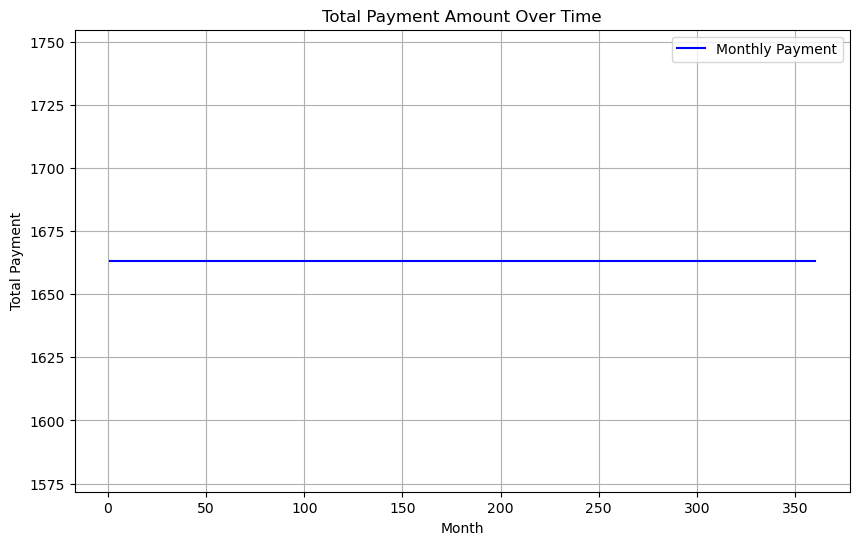

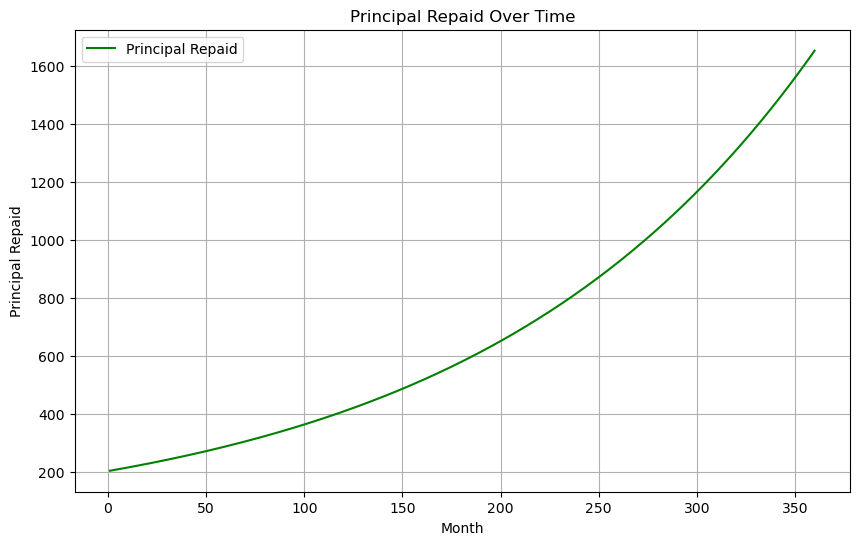

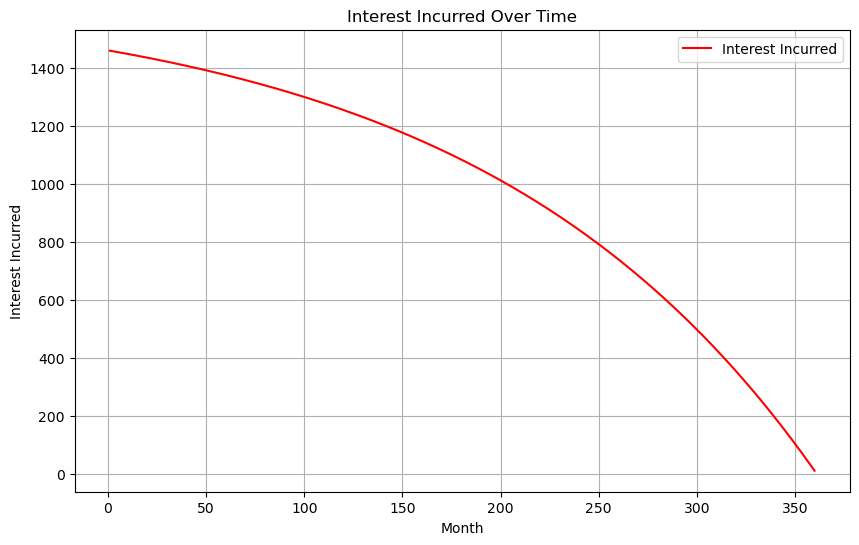

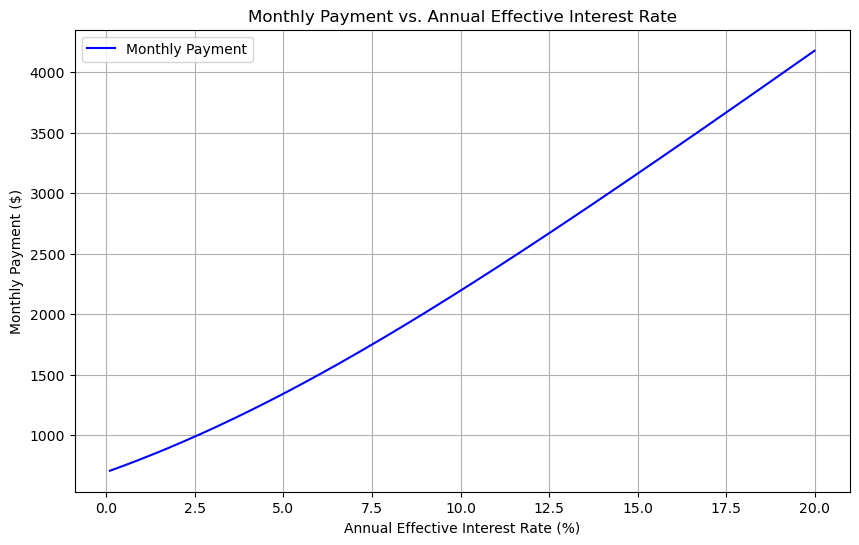

In [38]:
# a) Calc payment

L = 250000  
annual_effective_rate = 0.07  
year_loan = 30  
monthly_rate = annual_effective_rate / 12
total_payments = year_loan * 12
monthly_payment = L * monthly_rate * (1 + monthly_rate) ** total_payments / ((1 + monthly_rate) ** total_payments - 1)
monthly_payment = round(monthly_payment, 2)

print(f"Monthly payment: ${monthly_payment}")



# b) Plot interest and principal

total_payments_list = []
principal_repaid_list = []
interest_incurred_list = []

# Calculation monthly payment
monthly_payment = L * monthly_rate / (1 - (1 + monthly_rate) ** -total_payments)

# Initialize the remaining balance to the principal amount
remaining_balance = L

# Calculate and store values
for _ in range(total_payments):
    interest_incurred = remaining_balance * monthly_rate
    principal_repaid = monthly_payment - interest_incurred
    remaining_balance -= principal_repaid

    total_payments_list.append(monthly_payment)
    principal_repaid_list.append(principal_repaid)
    interest_incurred_list.append(interest_incurred)

# Create a range of months for the x-axis
months = list(range(1, total_payments + 1))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(months, total_payments_list, label='Monthly Payment', color='blue')
plt.title('Total Payment Amount Over Time')
plt.xlabel('Month')
plt.ylabel('Total Payment')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(months, principal_repaid_list, label='Principal Repaid', color='green')
plt.title('Principal Repaid Over Time')
plt.xlabel('Month')
plt.ylabel('Principal Repaid')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(months, interest_incurred_list, label='Interest Incurred', color='red')
plt.title('Interest Incurred Over Time')
plt.xlabel('Month')
plt.ylabel('Interest Incurred')
plt.grid(True)
plt.legend()
plt.show()




# c) Plot payment against rates


L = 250000  # Loan amount
year_loan = 30  # Loan term in years


annual_effective_rates = np.arange(0.001, 0.201, 0.001) 
monthly_payments = []

# Calculate the monthly payment 
for annual_effective_rate in annual_effective_rates:
    
    monthly_rate = annual_effective_rate / 12
    total_payments = year_loan * 12

    # Calculate the monthly payment using the formula
    monthly_payment = L * monthly_rate * (1 + monthly_rate) ** total_payments / ((1 + monthly_rate) ** total_payments - 1)
    
    monthly_payments.append(monthly_payment)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(annual_effective_rates * 100, monthly_payments, label='Monthly Payment', color='blue')
plt.title('Monthly Payment vs. Annual Effective Interest Rate')
plt.xlabel('Annual Effective Interest Rate (%)')
plt.ylabel('Monthly Payment ($)')
plt.grid(True)
plt.legend()
plt.show()
